In [1]:
import os
from glob import glob
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
import numpy as np
from netCDF4 import Dataset
from scipy.io import loadmat
import gsw

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster(cores=6, processes=12) # necessary?
    w = cluster.scale(jobs=10)
    # 3 needed for lagrangian lon/lat binning
    # 15 for eulerian binning
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Client Scheduler: tcp://10.148.0.135:40229 Dashboard: http://10.148.0.135:8787/status,Cluster Workers: 72 Cores: 288 Memory: 670.32 GiB


___________
# 1. Read Zach's data, and store as .nc files every one hour (9415 .nc files) 

In [5]:
# the path where (Zach's) LLC4320 data are already stored
LLC_data_folder = '/home1/datawork/xyu/OSMOSIS_llc4320/'
# the path where the data will be re-stored
out_dir_nc = '/home1/scratch/xyu/OSMOSIS_llc4320/nc_file/'

out_dir_grid = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'
out_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/'

grid = xr.open_dataset(out_dir_grid+'Grid.nc', decode_coords=True)

# variable 
v1 = 'Theta'
v2 = 'Salt'
v = 'Pden'

In [6]:
def density(Salt,Theta,depth,lon,lat):
    SA = gsw.SA_from_SP(Salt, depth, lon, lat)
    CT = gsw.CT_from_pt(SA, Theta)
    return gsw.density.sigma0(SA, CT)

In [7]:
# it may take over 1 hour
out_dir_nc = '/home1/scratch/xyu/OSMOSIS_llc4320/'

# search for right files, for example: Theta_177x201x52.*
filenames1 = sorted(glob(LLC_data_folder+v1+'/'+v1+'_177x201x52.*')) 
filenames2 = sorted(glob(LLC_data_folder+v2+'/'+v2+'_177x201x52.*')) 

print('Number of files processed: %d' %len(filenames1))

# store in netcdf files
fsize_bound = 5*1e6

for i in np.arange(len(filenames1)):
#for i in np.arange(20):

    #
    file_out = out_dir_nc+'/%s_t%05d.nc'%(v, i)
          
    if not os.path.isfile(file_out) or os.path.getsize(file_out) < fsize_bound:            
        
        ds1 = np.fromfile(filenames1[i] , dtype='>f').reshape(52,201,177)
        ds2 = np.fromfile(filenames2[i] , dtype='>f').reshape(52,201,177)
        depth = np.array(grid.Depth, dtype='>f')
        lon = np.array(grid.XC, dtype='>f')
        lat = np.array(grid.YC, dtype='>f')
        ds = density(ds2,ds1,depth,lon,lat)
        ds = np.array(ds, dtype='>f')
        ds = xr.DataArray(ds, dims=['depth','lat','lon'])
        ds = np.real(ds).rename(v)
        ds = ds.load() # this may be required in order to prevent pickle related errors
        #
        while True:
            try:
                ds.to_netcdf(file_out, mode='w', unlimited_dims=['time'])

            except:
                print('failure')
            break

    else:
        print('t=%d - allready processed'%(i))

Number of files processed: 9415


# 2. Add coordinates and put variables into one xarray file

In [8]:
filenames = sorted(glob(out_dir_nc+v+'_t*.nc')) 
print('Number of files processed: %d' %len(filenames))
%time ds = xr.open_mfdataset(filenames, concat_dim="time",combine="nested")
print(ds) 

Number of files processed: 9415
CPU times: user 31.3 s, sys: 36.3 s, total: 1min 7s
Wall time: 1min 26s
<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Dimensions without coordinates: depth, lat, lon, time
Data variables:
    Pden     (time, depth, lat, lon) float32 dask.array<chunksize=(1, 52, 201, 177), meta=np.ndarray>


In [9]:
Depth = loadmat(LLC_data_folder+'grid/dpt52.mat')['dpt52']
Depth = np.array(Depth)
Depth = xr.DataArray(Depth, dims=['none','depth'])
Depth = xr.DataArray.squeeze(Depth, dim='none')
Depth = np.real(Depth).rename('Depth')

In [10]:
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime.datetime(2011,9,13)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

In [11]:
ds = ds.assign_coords(depth=Depth) 
ds = ds.assign_coords(time=np.arange(len(filenames))*3600/86400) 
print(ds)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
Dimensions without coordinates: lat, lon
Data variables:
    Pden     (time, depth, lat, lon) float32 dask.array<chunksize=(1, 52, 201, 177), meta=np.ndarray>


In [12]:
chunks = {'time': 9415, 'lat': 1, 'lon': 177, 'depth':1}
ds = ds.chunk(chunks)
print(ds)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
Dimensions without coordinates: lat, lon
Data variables:
    Pden     (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 1, 177), meta=np.ndarray>


In [13]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'
out_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/'

file_out = out_dir_zarr+'/%s_total_rechunk.zarr'%(v)
%time ds.to_zarr(file_out, mode='w')

CPU times: user 1min 32s, sys: 2.28 s, total: 1min 34s
Wall time: 2min 5s


# Read re-chunked data

In [14]:
ds1 = xr.open_zarr(out_dir_zarr+'Pden_total_rechunk.zarr')
grid = xr.open_dataset('/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/Grid.nc', decode_coords=True)
ds3 = xr.merge([ds1,grid])
ds3

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(9415, 52, 201, 177)","(9415, 1, 1, 177)"
Count,10453 Tasks,10452 Chunks
Type,float32,numpy.ndarray


CPU times: user 68 ms, sys: 4 ms, total: 72 ms
Wall time: 337 ms


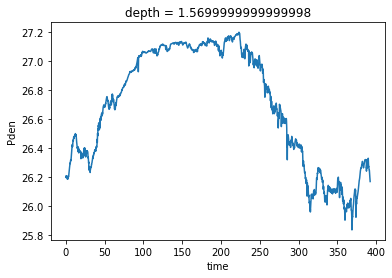

In [15]:
%time ds3.Pden.isel(depth=1, lat=slice(90,100), lon=slice(90,100)).mean(dim=['lat','lon']).plot()

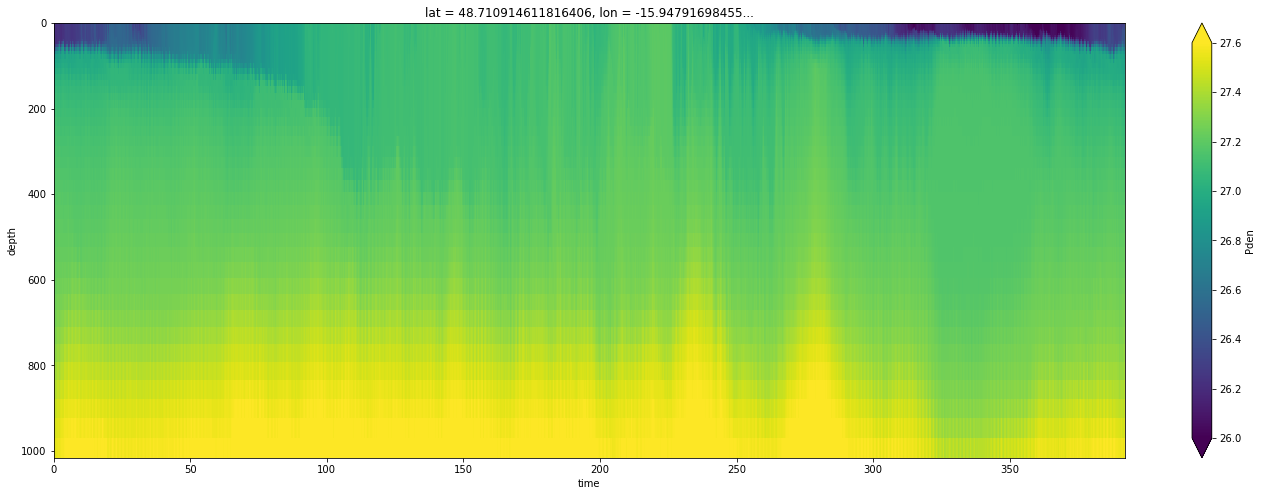

In [17]:
fig = plt.figure(figsize=(24,8))
plt.subplot(111)
ds3.Pden.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=26,vmax=27.6, yincrease=False)

_________
## 3. Steric height

In [4]:
# the path where (Zach's) LLC4320 data are already stored
LLC_data_folder = '/home1/datawork/xyu/OSMOSIS_llc4320/'
out_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/'

In [5]:
LLC_XC = np.fromfile(LLC_data_folder+"grid/XC_177x201", dtype='>f').reshape(201,177)
LLC_XC = np.array(LLC_XC)
LLC_XC = xr.DataArray(LLC_XC, dims=['lat','lon'])
LLC_XC = np.real(LLC_XC).rename('LLC_XC')

In [6]:
LLC_YC = np.fromfile(LLC_data_folder+"grid/YC_177x201", dtype='>f').reshape(201,177)
LLC_YC = np.array(LLC_YC)
LLC_YC = xr.DataArray(LLC_YC, dims=['lat','lon'])
LLC_YC = np.real(LLC_YC).rename('LLC_YC')

In [7]:
ds_Pden = xr.open_zarr(out_dir_zarr+'Pden_total_rechunk.zarr')

lat = LLC_YC.isel(lon=1)
lon = LLC_XC.isel(lat=1)
ds_Pden = ds_Pden.assign_coords(lat=lat) 
ds_Pden = ds_Pden.assign_coords(lon=lon)
print(ds_Pden)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat      (lat) >f4 47.4 47.42 47.43 47.44 47.46 ... 49.95 49.96 49.98 49.99
  * lon      (lon) >f4 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
Data variables:
    Pden     (time, depth, lat, lon) float32 dask.array<chunksize=(9415, 1, 1, 177), meta=np.ndarray>


In [14]:
ds1 = xr.open_zarr(out_dir_zarr+'Pden_total_rechunk.zarr')
grid = xr.open_dataset('/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/Grid.nc', decode_coords=True)
ds3 = xr.merge([ds1,grid])
ds3

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(9415, 52, 201, 177)","(9415, 1, 1, 177)"
Count,10453 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [8]:
density0 = ds_Pden.Pden.mean(['depth','time'])
density_prime = (ds_Pden.Pden-density0)/(density0 + 1000)
density_prime

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(9415, 52, 201, 177)","(9415, 1, 1, 177)"
Count,53065 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [9]:
print(density_prime.depth[16])
print(density_prime.depth[39])
print(density_prime.depth[-1])

<xarray.DataArray 'depth' ()>
array(52.69)
Coordinates:
    depth    float64 52.69
<xarray.DataArray 'depth' ()>
array(506.54)
Coordinates:
    depth    float64 506.5
<xarray.DataArray 'depth' ()>
array(992.26)
Coordinates:
    depth    float64 992.3


In [10]:
steric_height_0_500 = density_prime.isel(depth=slice(0,39)).integrate("depth")
steric_height_0_1000 = density_prime.integrate("depth")
steric_height_50_500 = density_prime.isel(depth=slice(16,39)).integrate("depth")
steric_height_50_1000 = density_prime.isel(depth=slice(16,-1)).integrate("depth")

In [11]:
steric_height_0_500 = np.real(steric_height_0_500).rename('steric_height_0_500').astype('float32')
steric_height_0_1000 = np.real(steric_height_0_1000).rename('steric_height_0_1000').astype('float32')
steric_height_50_500 = np.real(steric_height_50_500).rename('steric_height_50_500').astype('float32')
steric_height_50_1000 = np.real(steric_height_50_1000).rename('steric_height_50_1000').astype('float32')

In [18]:
steric_height_0_1000.persist()
steric_height_50_1000.persist()
steric_height_0_500.persist()
steric_height_50_500.persist()

<xarray.DataArray 'steric_height_50_500' (time: 9415, lat: 201, lon: 177)>
dask.array<astype, shape=(9415, 201, 177), dtype=float32, chunksize=(9415, 1, 177), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat      (lat) >f4 47.4 47.42 47.43 47.44 47.46 ... 49.95 49.96 49.98 49.99
  * lon      (lon) >f4 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [14]:
file_out = out_dir_zarr+'/steric_height_0_1000.nc'
%time steric_height_0_1000.to_dataset().to_netcdf(file_out, mode='w')

CPU times: user 29.8 s, sys: 1.34 s, total: 31.1 s
Wall time: 2min 56s


In [17]:
file_out = out_dir_zarr+'/steric_height_50_1000.nc'
%time steric_height_50_1000.to_dataset().to_netcdf(file_out, mode='w')

CPU times: user 1min 31s, sys: 4.8 s, total: 1min 36s
Wall time: 8min 59s


In [19]:
file_out = out_dir_zarr+'/steric_height_0_500.nc'
%time steric_height_0_500.to_dataset().to_netcdf(file_out, mode='w')

CPU times: user 2min 7s, sys: 6.1 s, total: 2min 13s
Wall time: 8min 40s


In [20]:
file_out = out_dir_zarr+'/steric_height_50_500.nc'
%time steric_height_50_500.to_dataset().to_netcdf(file_out, mode='w')

CPU times: user 1min 23s, sys: 4.54 s, total: 1min 27s
Wall time: 7min 23s


In [21]:
ds_sh = xr.merge([steric_height_0_500,steric_height_0_1000,steric_height_50_500,steric_height_50_1000])
print(ds_sh)
ds_sh.persist()

<xarray.Dataset>
Dimensions:                (lat: 201, lon: 177, time: 9415)
Coordinates:
  * time                   (time) float64 0.0 0.04167 0.08333 ... 392.2 392.2
  * lat                    (lat) >f4 47.4 47.42 47.43 ... 49.96 49.98 49.99
  * lon                    (lon) >f4 -18.03 -18.01 -17.99 ... -14.39 -14.36
Data variables:
    steric_height_0_500    (time, lat, lon) float32 dask.array<chunksize=(9415, 1, 177), meta=np.ndarray>
    steric_height_0_1000   (time, lat, lon) float32 dask.array<chunksize=(9415, 1, 177), meta=np.ndarray>
    steric_height_50_500   (time, lat, lon) float32 dask.array<chunksize=(9415, 1, 177), meta=np.ndarray>
    steric_height_50_1000  (time, lat, lon) float32 dask.array<chunksize=(9415, 1, 177), meta=np.ndarray>


<xarray.Dataset>
Dimensions:                (lat: 201, lon: 177, time: 9415)
Coordinates:
  * time                   (time) float64 0.0 0.04167 0.08333 ... 392.2 392.2
  * lat                    (lat) >f4 47.4 47.42 47.43 ... 49.96 49.98 49.99
  * lon                    (lon) >f4 -18.03 -18.01 -17.99 ... -14.39 -14.36
Data variables:
    steric_height_0_500    (time, lat, lon) float32 dask.array<chunksize=(9415, 1, 177), meta=np.ndarray>
    steric_height_0_1000   (time, lat, lon) float32 dask.array<chunksize=(9415, 1, 177), meta=np.ndarray>
    steric_height_50_500   (time, lat, lon) float32 dask.array<chunksize=(9415, 1, 177), meta=np.ndarray>
    steric_height_50_1000  (time, lat, lon) float32 dask.array<chunksize=(9415, 1, 177), meta=np.ndarray>

In [22]:
file_out = out_dir_zarr+'/steric_height.nc'
%time ds_sh.to_netcdf(file_out, mode='w')

KeyboardInterrupt: 

In [15]:
steric_height = xr.open_dataset(out_dir_zarr+'steric_height_0_1000.nc')
steric_height

<xarray.Dataset>
Dimensions:               (lat: 201, lon: 177, time: 9415)
Coordinates:
  * time                  (time) float64 0.0 0.04167 0.08333 ... 392.2 392.2
  * lat                   (lat) float32 47.4 47.42 47.43 ... 49.96 49.98 49.99
  * lon                   (lon) float32 -18.03 -18.01 -17.99 ... -14.39 -14.36
Data variables:
    steric_height_0_1000  (time, lat, lon) float32 ...

In [7]:
# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

steric_height = steric_height.assign_coords(time=time_day) 

chunks = {'time': 9415, 'lat': 1, 'lon': 177}
steric_height = steric_height.chunk(chunks)
print(steric_height)

<xarray.Dataset>
Dimensions:              (lat: 201, lon: 177, time: 9415)
Coordinates:
  * time                 (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:0...
  * lat                  (lat) float32 47.4 47.42 47.43 ... 49.96 49.98 49.99
  * lon                  (lon) float32 -18.03 -18.01 -17.99 ... -14.39 -14.36
Data variables:
    steric_height_0_500  (time, lat, lon) float64 dask.array<chunksize=(9415, 1, 177), meta=np.ndarray>


In [9]:
steric_height_0_500m = steric_height_0_500.isel(lat=slice(60,150), lon=slice(50,150)).sel(time=slice('2011-09-13T00:00:00','2012-09-13T00:00:00'))
chunks = {'time': 9415, 'lat': 1, 'lon': 177}
steric_height_0_500m = steric_height_0_500m.chunk(chunks)
steric_height_0_500m = np.real(steric_height_0_500m).rename('steric_height_0_500m')
file_out = out_dir_zarr+'/steric_height_0_500m.nc'
%time steric_height_0_500m.to_netcdf(file_out, mode='w')

<xarray.Dataset>
Dimensions:              (lat: 90, lon: 100, time: 8785)
Coordinates:
  * time                 (time) datetime64[ns] 2011-09-13 ... 2012-09-13
  * lat                  (lat) float32 48.19 48.2 48.22 ... 49.31 49.33 49.34
  * lon                  (lon) float32 -16.99 -16.97 -16.95 ... -14.95 -14.93
Data variables:
    steric_height_0_500  (time, lat, lon) float64 dask.array<chunksize=(8785, 1, 100), meta=np.ndarray>

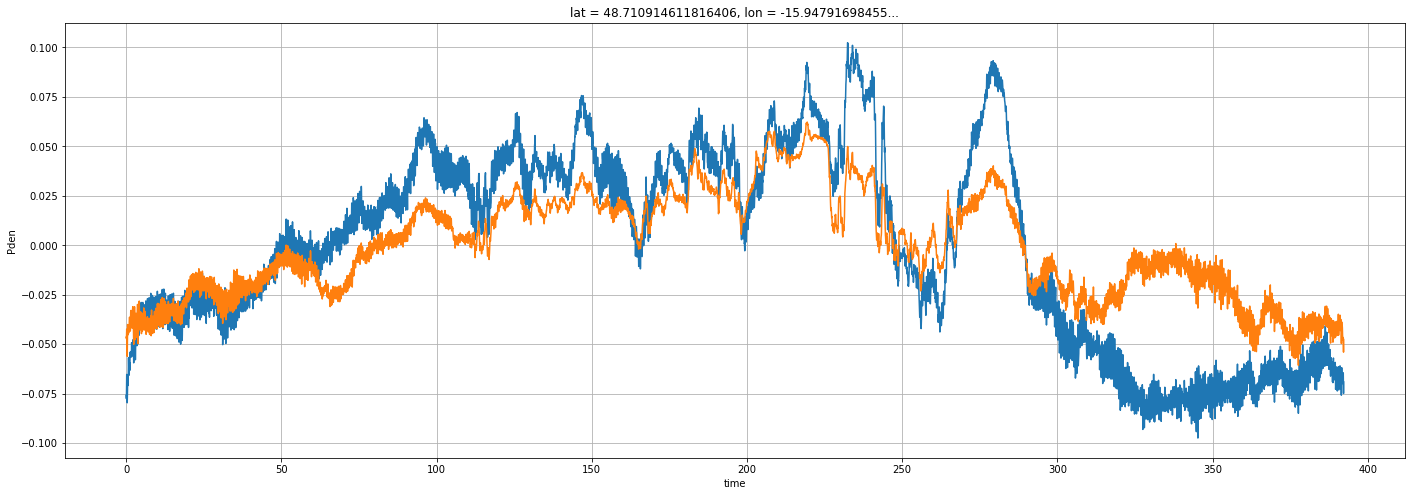

In [44]:
fig = plt.figure(figsize=(24,8))
plt.subplot(111)
( sh_i.isel(lat=100,lon=100) - sh_i.isel(lat=100,lon=100).mean('time') ).plot(x='time')
( sh_i_sel1.isel(lat=100,lon=100)  - sh_i_sel1.isel(lat=100,lon=100).mean('time') ).plot(x='time')
#( sh_i_sel2.isel(lat=100,lon=100)  - sh_i_sel2.isel(lat=100,lon=100).mean('time') ).plot(x='time')
#( sh_i_sel3.isel(lat=100,lon=100)  - sh_i_sel3.isel(lat=100,lon=100).mean('time') ).plot(x='time')

plt.grid()

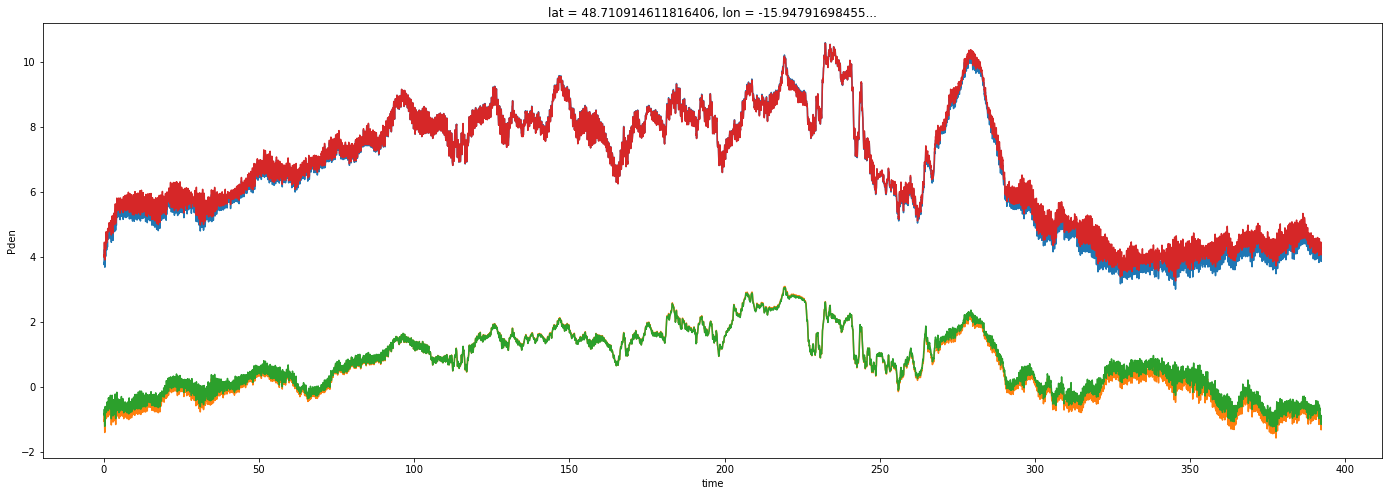

In [39]:
fig = plt.figure(figsize=(24,8))
plt.subplot(111)
sh_i.isel(lat=100,lon=100).plot(x='time')
sh_i_sel1.isel(lat=100,lon=100).plot(x='time')
sh_i_sel2.isel(lat=100,lon=100).plot(x='time')
sh_i_sel3.isel(lat=100,lon=100).plot(x='time')

In [24]:
cluster.close()